# Preprocessing Training and Modeling

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

## Preprocessing and Understanding

In [2]:
df = pd.read_csv('fraudTrain.csv')

In [3]:
# Deleted first column since it was the same as the index
df = df.iloc[: , 1:]
# We are going to rename some columns for ease
df = df.rename(columns={'trans_date_trans_time':'date_time'})
# Drop any duplicates
df.drop_duplicates(inplace=True)

In [4]:
df.shape

(1296675, 22)

In [5]:
# Let's downsize the data for ease of speed
df = df.sample(frac=0.01)
df.shape

(12967, 22)

In [6]:
df.head()

,date_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
146155,2019-03-19 23:32:48,4900628639996,"fraud_Hyatt, Russel and Gleichner",health_fitness,13.59,Michael,Johnson,M,094 Owens Underpass,Norwalk,...,33.9056,-118.0818,105549,Firefighter,1973-09-22,48d126431bdeaa6a00f8dda5c6b50ad3,1332199968,34.065722,-118.210461,0
965642,2020-01-25 08:07:12,213199865312311,fraud_Prohaska-Murray,gas_transport,56.44,Christopher,Miller,M,493 Fitzgerald Fields Suite 454,Varnell,...,34.9298,-84.9885,74,Pensions consultant,1944-05-14,f61df1b72610872bf9679520448cbbc5,1359101232,35.717384,-85.831533,0
85379,2019-02-19 16:52:22,4623560839669,fraud_Bahringer Group,health_fitness,68.67,Vincent,Waller,M,9379 Vanessa Run Apt. 400,Lohrville,...,42.2619,-94.5566,695,Administrator,1954-07-15,cb1b3817cb54e1caac80030442ee88d7,1329670342,42.274850,-94.885857,0
303410,2019-05-27 13:41:47,180067784565096,fraud_Friesen Ltd,health_fitness,48.04,Mary,Juarez,F,35440 Ryan Islands,North Prairie,...,42.9385,-88.3950,2328,Applications developer,1942-01-06,f410c5b655951ab704bd47d463633791,1338126107,43.651212,-88.412076,0
537391,2019-08-18 19:01:05,3567879740649740,fraud_Cruickshank-Mills,entertainment,3.32,Tanya,Williams,F,566 Megan Well,Brownville,...,44.0577,-76.0196,1271,"Producer, radio",1958-08-14,7d2f581fc4540ec766f1a465c7885ec1,1345316465,44.019274,-75.521793,0


In [7]:
df.columns

Index(['date_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long',
       'is_fraud'],
      dtype='object')

In [8]:
# No null data
df.isnull().sum()

date_time     0
cc_num        0
merchant      0
category      0
amt           0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
trans_num     0
unix_time     0
merch_lat     0
merch_long    0
is_fraud      0
dtype: int64

In [9]:
print(df['amt'].max())
print(df['amt'].min())

5122.54
1.0


Since there is a huge difference in the max and min values for the transaction amount, I will then scale this column to make the data more practical.

In [10]:
# We want to standardize the 'amt' column
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
amount = df['amt'].values
df['amt'] = sc.fit_transform(amount.reshape(-1, 1))
df['amt']

146155    -0.468829
965642    -0.106555
85379     -0.003156
303410    -0.177572
537391    -0.555657
             ...   
70380     -0.431460
1192604   -0.501802
479153     0.221818
920002    -0.248252
430241     0.554502
Name: amt, Length: 12967, dtype: float64

Everything in the 'amt' or Amount column looks like it has been scaled and so we will move onto the train and test split. While doing EDA, we found out that most of the columns are not correlated with wether or not the transaction is fraudulent. Therefore, we will create a new dataframe that focuses on the features we need. Additionally, it will save running time.

In [41]:
dfa = df[['amt', 'is_fraud']]
dft = df[['date_time', 'is_fraud']]

## Train Test Split - Time Series

The first step in creating an ARIMA model is checking if the series is stationary using the Dickey Fuller Test (ADF). The null hypothesis of the ADF test is that the time series is nonstationary. SO if the p-value of the test is less than the significance level (0.05), then we reject the null hypthesis and infer that the time series is stationary. If the p-value > 0.05, then we find the order of differencing.

In [12]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(dft.is_fraud)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -114.497139
p-value: 0.000000


Since P-value is greater than the significance level, let’s move on to see which is the best ARIMA order to use by using the auto_arima tool.

In [14]:
from pmdarima import auto_arima


model_arima= auto_arima(dft.is_fraud,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
              suppress_warnings=True,stepwise=False,seasonal=False)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-30543.321, Time=1.48 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-30541.321, Time=2.76 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-30541.823, Time=2.61 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-30539.824, Time=6.33 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-30541.321, Time=0.75 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-30539.321, Time=2.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-30539.824, Time=3.45 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-30537.824, Time=4.52 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-30541.823, Time=2.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-30539.823, Time=3.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-30537.824, Time=7.43 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-30536.256, Time=4.97 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-30539.823, Time=2.91 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-30537.823, Time=3.67 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-30535

In [15]:
from statsmodels.tsa.arima.model import ARIMA

series = dft.is_fraud
X = series
size = int(len(X) * 0.75)  
train, test = X[0:size], X[size:]
history = [x for x in train]
model = ARIMA(history, order=(0,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9725
Model:                          ARIMA   Log Likelihood               10736.121
Date:                Fri, 21 Oct 2022   AIC                         -21468.242
Time:                        10:47:03   BIC                         -21453.877
Sample:                             0   HQIC                        -21463.372
                               - 9725                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065     11.230      0.001      1.000     -22.003      22.016
sigma2         0.0064      0.146      0.044      0.965      -0.281       0.294
Ljung-Box (L1) (Q):                   0.41   Jarque-

### Plot Arima

In [25]:
forecast_test = model_fit.forecast(len(test))
forecast_test.shape

(3242,)

In [30]:
print(forecast_test)

[0.00647315 0.00647315 0.00647315 ... 0.00647315 0.00647315 0.00647315]


In [26]:
test.shape

(3242,)

In [28]:
print(dft['date_time'][size:])

462185     2019-07-22 20:41:48
748978     2019-11-16 20:36:53
363796     2019-06-17 19:21:21
117926     2019-03-07 21:25:02
679457     2019-10-16 22:09:43
                  ...         
70380      2019-02-11 10:47:10
1192604    2020-05-12 21:22:12
479153     2019-07-29 03:10:14
920002     2019-12-30 17:30:04
430241     2019-07-12 04:38:32
Name: date_time, Length: 3242, dtype: object


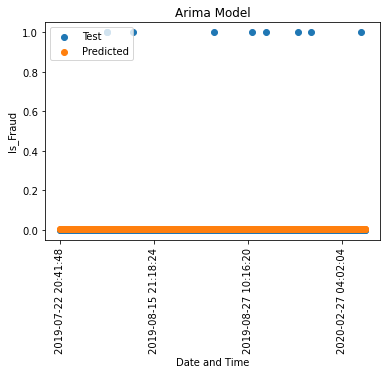

In [52]:
plt.scatter(dft['date_time'][size:], test, label="Test")
plt.scatter(dft['date_time'][size:], forecast_test, label="Predicted")
plt.xlabel('Date and Time')
plt.ylabel('Is_Fraud')
plt.legend(loc="upper left")
plt.xticks(np.arange(0, 3242, 1000), rotation = 90)
plt.title('Arima Model')
plt.show()

### Plot Residual

In [44]:
diff = test - forecast_test 

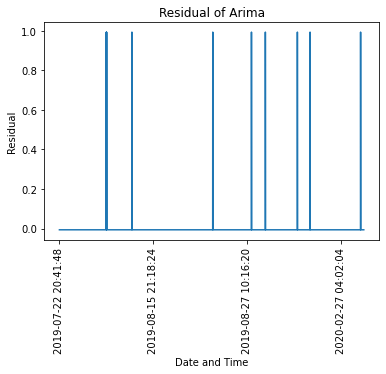

In [54]:
plt.plot(dft['date_time'][size:], diff)
plt.xticks(np.arange(0, 3242, 1000), rotation = 90)
plt.xlabel('Date and Time')
plt.ylabel('Residual')
plt.title('Residual of Arima')
plt.show()

In [55]:
from statistics import mean

avg = mean(diff)
print('The average of the residual is', avg)

The average of the residual is -0.003697082179960212


Although the average of the residual is low, however, we have to consider that the majority of the data is nonfraudulent data. If we look at the Arima model, it did not predict a single fraudulent behavior when there was some. Let's feed the residual with  the random forest model (with other characteristics).

### Random Forest on Residuals

In [69]:
df.head()

,date_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
146155,2019-03-19 23:32:48,4900628639996,"fraud_Hyatt, Russel and Gleichner",health_fitness,-0.468829,Michael,Johnson,M,094 Owens Underpass,Norwalk,...,33.9056,-118.0818,105549,Firefighter,1973-09-22,48d126431bdeaa6a00f8dda5c6b50ad3,1332199968,34.065722,-118.210461,0
965642,2020-01-25 08:07:12,213199865312311,fraud_Prohaska-Murray,gas_transport,-0.106555,Christopher,Miller,M,493 Fitzgerald Fields Suite 454,Varnell,...,34.9298,-84.9885,74,Pensions consultant,1944-05-14,f61df1b72610872bf9679520448cbbc5,1359101232,35.717384,-85.831533,0
85379,2019-02-19 16:52:22,4623560839669,fraud_Bahringer Group,health_fitness,-0.003156,Vincent,Waller,M,9379 Vanessa Run Apt. 400,Lohrville,...,42.2619,-94.5566,695,Administrator,1954-07-15,cb1b3817cb54e1caac80030442ee88d7,1329670342,42.274850,-94.885857,0
303410,2019-05-27 13:41:47,180067784565096,fraud_Friesen Ltd,health_fitness,-0.177572,Mary,Juarez,F,35440 Ryan Islands,North Prairie,...,42.9385,-88.3950,2328,Applications developer,1942-01-06,f410c5b655951ab704bd47d463633791,1338126107,43.651212,-88.412076,0
537391,2019-08-18 19:01:05,3567879740649740,fraud_Cruickshank-Mills,entertainment,-0.555657,Tanya,Williams,F,566 Megan Well,Brownville,...,44.0577,-76.0196,1271,"Producer, radio",1958-08-14,7d2f581fc4540ec766f1a465c7885ec1,1345316465,44.019274,-75.521793,0


In [150]:
# create a new dataframe from the residuals
df_rf = pd.DataFrame(diff)
df_rf = df_rf.rename(columns = {'is_fraud':'residual'})

In [179]:
df_rf['date_time'] = df['date_time'][size:]
df_rf['amt'] = df['amt'][size:]
df_rf['city_pop'] = df['city_pop'][size:]
df_rf['is_fraud'] = df['is_fraud'][size:]
df_rf.reset_index(drop=True)

,residual,amt,city_pop,is_fraud,date_time
0,-0.006473,-0.355877,2526,0,2019-07-22 20:41:48
1,-0.006473,-0.282408,239,0,2019-11-16 20:36:53
2,-0.006473,0.571918,1506,0,2019-06-17 19:21:21
3,-0.006473,-0.457754,2523,0,2019-03-07 21:25:02
4,-0.006473,-0.562505,1334,0,2019-10-16 22:09:43
...,...,...,...,...,...
3237,-0.006473,-0.431460,753116,0,2019-02-11 10:47:10
3238,-0.006473,-0.501802,5760,0,2020-05-12 21:22:12
3239,-0.006473,0.221818,302,0,2019-07-29 03:10:14
3240,-0.006473,-0.248252,1078,0,2019-12-30 17:30:04


In [180]:
from sklearn.model_selection import train_test_split

X = df_rf[['amt', 'city_pop']]
y = df_rf['is_fraud']

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [182]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [183]:
sel.get_support()

array([ True, False])

This means that between transaction amount and city population, transaction amount is the best feature we should look at.

In [184]:
# It will return an Integer representing the number of features selected by the random forest

selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

1

In [185]:
print(selected_feat)

Index(['amt'], dtype='object')


Seeing as transaction amount is the best feature to look at, we will do further analysis on transaction amount and the residuals from our arima model in the next section.

## Train Test Split - Amount

In [12]:
X = dfa.drop('is_fraud', axis = 1).values
y = dfa['is_fraud'].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

### Decision Tree Classifier

In [14]:
DT = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
DT.fit(X_train, y_train)
dt_yhat = DT.predict(X_test)

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print('Accuracy score of the Decision Tree model is {}'.format(accuracy_score(y_test, dt_yhat)))
print('F1 score of the Decision Tree model is {}'.format(f1_score(y_test, dt_yhat)))
confusion_matrix(y_test, dt_yhat, labels = [0, 1])

Accuracy score of the Decision Tree model is 0.9944478716841456
F1 score of the Decision Tree model is 0.43749999999999994


array([[3217,   10],
       [   8,    7]], dtype=int64)

Here, the first row represents positive and the second row represents negative. So, we have 3219 as true positive and 0 are false positive. We have 3219 that are successfully classified as a nonfraudulent transaction and 0 were falsely classified as nonfraudulent, but they were fraudulent. For the accuracy and F1 score, generally we want the score closer to 1. The accuracy score of the Decision Tree model is pretty good but the F1 score is alright.

### K-Nearest Neighbors

In [16]:
from sklearn.neighbors import KNeighborsClassifier

n = 7
KNN = KNeighborsClassifier(n_neighbors = n)
KNN.fit(X_train, y_train)
knn_yhat = KNN.predict(X_test)

In [17]:
print('Accuracy score of the K-Nearest Neighbors model is {}'.format(accuracy_score(y_test, knn_yhat)))
print('F1 score of the K-Nearest Neighbors model is {}'.format(f1_score(y_test, knn_yhat)))
confusion_matrix(y_test, knn_yhat, labels = [0, 1])

Accuracy score of the K-Nearest Neighbors model is 0.9956816779765577
F1 score of the K-Nearest Neighbors model is 0.4615384615384615


array([[3222,    5],
       [   9,    6]], dtype=int64)

### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)

In [19]:
print('Accuracy score of the Logistic Regression model is {}'.format(accuracy_score(y_test, lr_yhat)))
print('F1 score of the Logistic Regression model is {}'.format(f1_score(y_test, lr_yhat)))
confusion_matrix(y_test, lr_yhat, labels = [0, 1])

Accuracy score of the Logistic Regression model is 0.9953732264034546
F1 score of the Logistic Regression model is 0.0


array([[3227,    0],
       [  15,    0]], dtype=int64)

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 4)
rf.fit(X_train, y_train)
rf_yhat = rf.predict(X_test)

In [21]:
print('Accuracy score of the Random Forest model is {}'.format(accuracy_score(y_test, rf_yhat)))
print('F1 score of the Random Forest model is {}'.format(f1_score(y_test, rf_yhat)))
confusion_matrix(y_test, rf_yhat, labels = [0, 1])

Accuracy score of the Random Forest model is 0.9953732264034546
F1 score of the Random Forest model is 0.4444444444444445


array([[3221,    6],
       [   9,    6]], dtype=int64)

### XGBoost

In [22]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth = 4)
xgb.fit(X_train, y_train)
xgb_yhat = xgb.predict(X_test)

In [23]:
print('Accuracy score of the XGBoost model is {}'.format(accuracy_score(y_test, xgb_yhat)))
print('F1 score of the XGBoost model is {}'.format(f1_score(y_test, xgb_yhat)))
confusion_matrix(y_test, xgb_yhat, labels = [0, 1])

Accuracy score of the XGBoost model is 0.9953732264034546
F1 score of the XGBoost model is 0.3478260869565218


array([[3223,    4],
       [  11,    4]], dtype=int64)

### Hybrid XGBoost Model - XGBoost and Random Forest Classifier

In [24]:
from xgboost import XGBRFClassifier

xgbrf = XGBRFClassifier()
xgbrf.fit(X_train, y_train)
xgbrf_yhat = xgb.predict(X_test)

In [25]:
print('Accuracy score of the XGBRF model is {}'.format(accuracy_score(y_test, xgbrf_yhat)))
print('F1 score of the XGBRF model is {}'.format(f1_score(y_test, xgbrf_yhat)))
confusion_matrix(y_test, xgbrf_yhat, labels = [0, 1])

Accuracy score of the XGBRF model is 0.9953732264034546
F1 score of the XGBRF model is 0.3478260869565218


array([[3223,    4],
       [  11,    4]], dtype=int64)

## Overall Scores

In [26]:
accuracy = [accuracy_score(y_test, dt_yhat), accuracy_score(y_test, knn_yhat), accuracy_score(y_test, lr_yhat), 
            accuracy_score(y_test, xgb_yhat), accuracy_score(y_test, xgbrf_yhat)]
f1 = [f1_score(y_test, dt_yhat), f1_score(y_test, knn_yhat), f1_score(y_test, lr_yhat), 
            f1_score(y_test, xgb_yhat), f1_score(y_test, xgbrf_yhat)]
names = ['DT', 'KNN', 'LR', 'XGB', 'XBGRF']

In [27]:
def scores(accuracy, f1, names):
    for i in range(0, 5):
        print('For', names[i])
        print('It has an accuracy score of', accuracy[i])
        print('And an F1 score of', f1[i])

In [28]:
scores(accuracy, f1, names)

For DT
It has an accuracy score of 0.9944478716841456
And an F1 score of 0.43749999999999994
For KNN
It has an accuracy score of 0.9956816779765577
And an F1 score of 0.4615384615384615
For LR
It has an accuracy score of 0.9953732264034546
And an F1 score of 0.0
For XGB
It has an accuracy score of 0.9953732264034546
And an F1 score of 0.3478260869565218
For XBGRF
It has an accuracy score of 0.9953732264034546
And an F1 score of 0.3478260869565218


In [29]:
max(accuracy)

0.9956816779765577

In [30]:
max(f1)

0.4615384615384615

Decision Tree Classifier has the highest accuracy score but XGBoost and XGBoost/Random Forest has the highest F1 score. So how do we choose between the two?

### Explanation

Remember that the F1 score is balancing precision and recall on the positive class while accuracy looks at correctly classified observations both positive and negative. That makes a big difference especially for the imbalanced problems where by default our model will be good at predicting true negatives and hence accuracy will be high. However, if you care equally about true negatives and true positives then accuracy is the metric you should choose. 

Since our dataset is naturally imbalanced, it will make our accuracy score really high by default. That is why we will care more about the F1 score in this case.

Therefore, the best model is the XGBoost and XGBRF which has the same accuracy and F1 score. We have an accuracy of 99.35% and a F1 score of 32.26%

### Using Random Forest on Residuals

In [201]:
X_test = df_rf['residual'][int(len(df_rf)*0.75):].values
X_train = df_rf['residual'][:int(len(df_rf)*0.75)].values
print(X_train.shape)
print(X_test.shape)

(2431,)
(811,)


In [205]:
y_test = df_rf['is_fraud'][int(len(df_rf)*0.75):].values
y_train = df_rf['is_fraud'][:int(len(df_rf)*0.75)].values

In [207]:
rf = RandomForestClassifier(max_depth = 4)
rf.fit(X_train.reshape(-1,1), y_train)
rf_yhat = rf.predict(X_test)

ValueError: Expected 2D array, got 1D array instead:
array=[-0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315  0.9935269  -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315  0.9935269  -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315  0.9935269  -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315 -0.00647315
 -0.00647315].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.